In [1]:
import os
import sys

# torch modules
from torch import nn, optim, load
from torchvision import transforms, models

# Add to pythonpath so package imports work when run as module
# BREED_ID_DIR = os.path.abspath(os.path.dirname(__file__))
# PROJ_DIR = os.path.join(BREED_ID_DIR, os.pardir)
# Uncomment below and comment above two lines for use in jupyter notebook
PROJ_DIR = os.path.abspath(os.path.join(os.pardir, os.pardir))
print('proj dir:', PROJ_DIR)
if PROJ_DIR not in sys.path:
    sys.path.append(PROJ_DIR)

# Package modules
from breed_id.breed_id_utils import LABELS_CSV_PATH, SAVED_MODELS_DIR
from breed_id.breed_id_utils import TRANSFORM_NORM, TRANSFORM_IMG_SIZE
from breed_id.data_loader import DataLoaderGenerator
from breed_id.train import Trainer

proj dir: /home/johnny/civic-projects/saveallthepets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

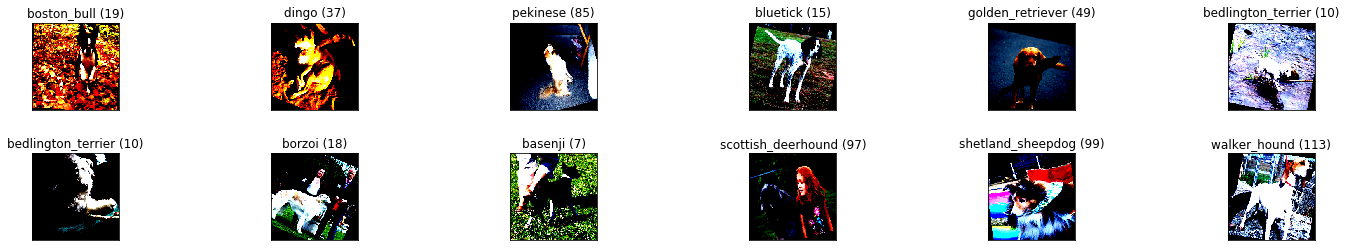

In [2]:
# Module constants
# Map to local directory of images
IMG_DIR = '/media/wdblack-1/saveallthepets/dog-breed-dataset/kaggle/train'
BATCH_SIZE = 32
# Imagenet models require 224x224 sized images except Inception which used 299
INPUT_SIZE = TRANSFORM_IMG_SIZE
VALIDATION_SPLIT = 0.20  # Train/validation subset ratio
RAND_STATE = 42  # Random state to help ensure reproducibility when an option
NUM_CLASSES = 120  # There are 120 breeds in this kaggle dataset

# 1. Define train and validation data transformers
train_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(degrees=25),
    transforms.ToTensor(),
    TRANSFORM_NORM
])
valid_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    TRANSFORM_NORM
])

# 2. Define loader configurations and generate dataloaders
loader_generator = DataLoaderGenerator(labels_path=LABELS_CSV_PATH,
                                       img_dir=IMG_DIR,
                                       split_size=VALIDATION_SPLIT,
                                       rand_state=RAND_STATE)
dataloaders = loader_generator.get_data_loaders(batch_size=BATCH_SIZE,
                                                shuffle=True, num_workers=4,
                                                pin_memory=True,
                                                train_transform=train_transforms,
                                                valid_transform=valid_transforms)
train_loader = dataloaders['train']
valid_loader = dataloaders['validation']

# Visualize a handful to ensure transformations make sense (OPTIONAL)
show_sample = True
if show_sample:
    loader_generator.show_sample_images(transform=train_transforms)

In [3]:
# 3. Define network model and freeze layers for use as feature extractor
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# 4. Reshape fully-connected layer
# Note: the name or structure is unique to each Imagenet model
# Useful reference link:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks
model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, NUM_CLASSES)
)

# OPTIONAL: load saved model
load_model = False
if load_model:
    model_checkpoint = load(os.path.join(SAVED_MODELS_DIR, 'R50_2nodes_model.pt'))
    model.load_state_dict(model_checkpoint['state_dict'])
    print(model_checkpoint.keys())

In [4]:
model.fc.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0211,  0.0162,  0.0211,  ..., -0.0116, -0.0168, -0.0024],
                      [ 0.0074, -0.0163,  0.0030,  ..., -0.0028, -0.0154, -0.0202],
                      [-0.0095,  0.0172,  0.0004,  ...,  0.0128,  0.0157,  0.0116],
                      ...,
                      [ 0.0128, -0.0101, -0.0063,  ...,  0.0126, -0.0157, -0.0182],
                      [ 0.0081,  0.0181, -0.0174,  ...,  0.0150,  0.0168,  0.0092],
                      [-0.0097,  0.0080,  0.0077,  ..., -0.0098,  0.0024,  0.0097]])),
             ('0.bias',
              tensor([ 0.0034,  0.0063, -0.0196,  ..., -0.0015,  0.0138, -0.0037])),
             ('2.weight',
              tensor([[ 0.0244,  0.0303,  0.0219,  ...,  0.0239, -0.0285, -0.0284],
                      [ 0.0143,  0.0135,  0.0198,  ..., -0.0183,  0.0267, -0.0193],
                      [-0.0233, -0.0066,  0.0293,  ...,  0.0221,  0.0283, -0.0217],
                      ...,
                      [ 0.

In [5]:
# 5. Define configurations for training: learning rate, loss model (criterion),
# optimizer, and scheduler (optional)
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=lr)
# Uncomment below and comment above is using unfrozen feature extractor layer
# optimizer = optim.Adam(model.parameters(), lr=lr)
# Allows for decreasing the learning rate per epoch rate
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,
                                      step_size=100, gamma=0.1)

In [6]:
# 6. Train model
# Base name for saving model checkpoints
base_name = 'R50_2048-1048_nodes'
epochs = 200
CUDA_INT = 0
trainer = Trainer(train_loader=train_loader, validation_loader=valid_loader,
                  criterion=criterion, optimizer=optimizer,
                  scheduler=scheduler, save_dir=SAVED_MODELS_DIR)
model_checkpoint = trainer.train_model(arch=base_name, model=model,
                                       epochs=epochs, device_int=CUDA_INT,
                                       unfreeze=False, checkpoint=None)

Training model on cuda:0


Epoch: 1 - completed in: 0m 33s
	Training Loss: 2.402543 	Validation Loss: 1.103086
	Training acc: 43.603 	Validation acc: 66.522
	Training mcc: 0.431 	Validation mcc: 0.663
Validation loss decreased (inf --> 1.103086).  Saving model ...
	Model saved as: R50_2048-1048_nodes_model_0.pt
Epoch: 2 - completed in: 0m 33s
	Training Loss: 1.122296 	Validation Loss: 1.002254
	Training acc: 66.854 	Validation acc: 69.437
	Training mcc: 0.666 	Validation mcc: 0.692
Validation loss decreased (1.103086 --> 1.002254).  Saving model ...
	Model saved as: R50_2048-1048_nodes_model_1.pt
Epoch: 3 - completed in: 0m 33s
	Training Loss: 0.988091 	Validation Loss: 0.913727
	Training acc: 70.605 	Validation acc: 72.200
	Training mcc: 0.704 	Validation mcc: 0.720
Validation loss decreased (1.002254 --> 0.913727).  Saving model ...
	Model saved as: R50_2048-1048_nodes_model_2.pt
Epoch: 4 - completed in: 0m 33s
	Training Loss: 0.932008 	Validation Loss: 0.860425
	Training acc: 71.150 	Validation acc: 73.857
	T

Epoch: 43 - completed in: 0m 34s
	Training Loss: 0.292255 	Validation Loss: 1.294998
	Training acc: 90.102 	Validation acc: 74.119
	Training mcc: 0.900 	Validation mcc: 0.739
Epoch: 44 - completed in: 0m 34s
	Training Loss: 0.308433 	Validation Loss: 1.285414
	Training acc: 89.581 	Validation acc: 73.163
	Training mcc: 0.895 	Validation mcc: 0.729
Epoch: 45 - completed in: 0m 34s
	Training Loss: 0.311963 	Validation Loss: 1.265204
	Training acc: 89.616 	Validation acc: 73.353
	Training mcc: 0.895 	Validation mcc: 0.731
Epoch: 46 - completed in: 0m 34s
	Training Loss: 0.297636 	Validation Loss: 1.281238
	Training acc: 90.251 	Validation acc: 73.890
	Training mcc: 0.902 	Validation mcc: 0.737
Epoch: 47 - completed in: 0m 34s
	Training Loss: 0.312926 	Validation Loss: 1.397068
	Training acc: 89.712 	Validation acc: 71.082
	Training mcc: 0.896 	Validation mcc: 0.709
Epoch: 48 - completed in: 0m 34s
	Training Loss: 0.294825 	Validation Loss: 1.210155
	Training acc: 90.188 	Validation acc: 7

Epoch: 90 - completed in: 0m 34s
	Training Loss: 0.203142 	Validation Loss: 1.706252
	Training acc: 93.849 	Validation acc: 73.109
	Training mcc: 0.938 	Validation mcc: 0.729
Epoch: 91 - completed in: 0m 34s
	Training Loss: 0.233861 	Validation Loss: 1.805162
	Training acc: 92.572 	Validation acc: 72.801
	Training mcc: 0.925 	Validation mcc: 0.726
Epoch: 92 - completed in: 0m 34s
	Training Loss: 0.247707 	Validation Loss: 1.844241
	Training acc: 92.459 	Validation acc: 72.138
	Training mcc: 0.924 	Validation mcc: 0.719
Epoch: 93 - completed in: 0m 34s
	Training Loss: 0.226792 	Validation Loss: 1.698001
	Training acc: 92.915 	Validation acc: 72.968
	Training mcc: 0.929 	Validation mcc: 0.727
Epoch: 94 - completed in: 0m 34s
	Training Loss: 0.226414 	Validation Loss: 1.733491
	Training acc: 93.034 	Validation acc: 73.320
	Training mcc: 0.930 	Validation mcc: 0.731
Epoch: 95 - completed in: 0m 34s
	Training Loss: 0.237787 	Validation Loss: 1.717318
	Training acc: 92.657 	Validation acc: 7

Epoch: 137 - completed in: 0m 34s
	Training Loss: 0.058526 	Validation Loss: 1.737035
	Training acc: 98.108 	Validation acc: 74.965
	Training mcc: 0.981 	Validation mcc: 0.748
Epoch: 138 - completed in: 0m 34s
	Training Loss: 0.058302 	Validation Loss: 1.703576
	Training acc: 98.086 	Validation acc: 75.322
	Training mcc: 0.981 	Validation mcc: 0.751
Epoch: 139 - completed in: 0m 34s
	Training Loss: 0.058710 	Validation Loss: 1.703398
	Training acc: 98.195 	Validation acc: 75.145
	Training mcc: 0.982 	Validation mcc: 0.750
Epoch: 140 - completed in: 0m 34s
	Training Loss: 0.058926 	Validation Loss: 1.656776
	Training acc: 98.109 	Validation acc: 75.458
	Training mcc: 0.981 	Validation mcc: 0.753
Epoch: 141 - completed in: 0m 34s
	Training Loss: 0.060634 	Validation Loss: 1.661104
	Training acc: 97.949 	Validation acc: 75.908
	Training mcc: 0.979 	Validation mcc: 0.757
Epoch: 142 - completed in: 0m 34s
	Training Loss: 0.059820 	Validation Loss: 1.648963
	Training acc: 97.999 	Validation 

Epoch: 184 - completed in: 0m 34s
	Training Loss: 0.046827 	Validation Loss: 1.694696
	Training acc: 98.453 	Validation acc: 75.184
	Training mcc: 0.985 	Validation mcc: 0.750
Epoch: 185 - completed in: 0m 34s
	Training Loss: 0.054869 	Validation Loss: 1.745395
	Training acc: 98.206 	Validation acc: 75.126
	Training mcc: 0.982 	Validation mcc: 0.749
Epoch: 186 - completed in: 0m 34s
	Training Loss: 0.050327 	Validation Loss: 1.695606
	Training acc: 98.367 	Validation acc: 75.566
	Training mcc: 0.984 	Validation mcc: 0.754
Epoch: 187 - completed in: 0m 34s
	Training Loss: 0.049023 	Validation Loss: 1.674144
	Training acc: 98.366 	Validation acc: 74.540
	Training mcc: 0.984 	Validation mcc: 0.743
Epoch: 188 - completed in: 0m 34s
	Training Loss: 0.052234 	Validation Loss: 1.691424
	Training acc: 98.124 	Validation acc: 75.800
	Training mcc: 0.981 	Validation mcc: 0.756
Epoch: 189 - completed in: 0m 34s
	Training Loss: 0.049272 	Validation Loss: 1.726626
	Training acc: 98.463 	Validation 

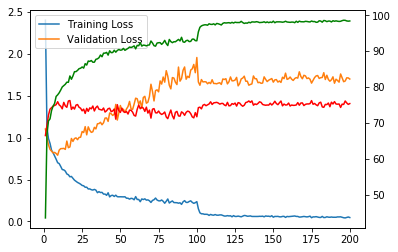

In [7]:
# 7. Visualize result of training
train_loss = model_checkpoint['train_loss']
valid_loss = model_checkpoint['valid_loss']
train_acc = model_checkpoint['train_acc']
valid_acc = model_checkpoint['valid_acc']
train_mcc = model_checkpoint['train_mcc']
valid_mcc = model_checkpoint['valid_mcc']
train_y_true = model_checkpoint['train_y_true']
train_y_pred = model_checkpoint['train_y_pred']
valid_y_true = model_checkpoint['valid_y_true']
valid_y_pred = model_checkpoint['valid_y_pred']

# Plot loss vs accuracy
trainer.plot_loss(arch=base_name, train_loss=train_loss,
                  valid_loss=valid_loss, train_metric=train_acc,
                  valid_metric=valid_acc, metric_title='Accuracy',
                  train_metric_label='Train Accuracy',
                  valid_metric_label='Validation Accuracy')
# # Plot loss vs mcc
# trainer.plot_loss(arch=base_name, train_loss=train_loss,
#                   valid_loss=valid_loss, train_metric=train_mcc,
#                   valid_metric=valid_mcc, metric_title='MCC',
#                   train_metric_label='Train MCC',
#                   valid_metric_label='Validation MCC')
# # Plot train confusion matrix
# trainer.plot_confusion_matrix(y_true=train_y_true, y_pred=train_y_pred,
#                               title=f'{base_name} Train Confusion Matrix')
# # Plot validation confusion matrix
# trainer.plot_confusion_matrix(y_true=valid_y_true, y_pred=valid_y_pred,
#                               title=f'{base_name} Valid Confusion Matrix')

In [8]:
model.fc.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0230,  0.0171,  0.0203,  ..., -0.0180, -0.0210, -0.0084],
                      [ 0.1956,  0.1625, -0.0651,  ...,  0.0252, -0.0259,  0.1422],
                      [-0.0163,  0.0123, -0.0057,  ...,  0.0042,  0.0069,  0.0048],
                      ...,
                      [ 0.0068, -0.0161, -0.0123,  ...,  0.0066, -0.0217, -0.0242],
                      [ 0.0021,  0.0121, -0.0115,  ...,  0.0090,  0.0228,  0.0032],
                      [-0.0237, -0.0109,  0.0018,  ..., -0.0266,  0.0129,  0.0135]],
                     device='cuda:0')),
             ('0.bias',
              tensor([ 0.0002,  0.0172, -0.0258,  ..., -0.0075,  0.0078, -0.0124],
                     device='cuda:0')),
             ('2.weight',
              tensor([[ 0.0133,  0.0069,  0.0125,  ...,  0.0180, -0.0345, -0.0434],
                      [ 0.0127, -0.3479,  0.0162,  ..., -0.0243,  0.0207, -0.0039],
                      [-0.0348, -0.2060,  0.0298,  ...,  0.01

In [11]:
model.load_state_dict(model_checkpoint['state_dict'])
model.fc.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0153,  0.0138,  0.0165,  ...,  0.0425,  0.0080,  0.0159],
                      [-0.0565,  0.0126,  0.0074,  ..., -0.1072,  0.0017, -0.0288],
                      [-0.0390, -0.0308, -0.0370,  ...,  0.0080, -0.0084, -0.0496],
                      ...,
                      [ 0.0392,  0.0017,  0.0435,  ...,  0.0106,  0.0634, -0.0406],
                      [-0.0601, -0.0239,  0.0498,  ..., -0.0199, -0.0222, -0.0087],
                      [ 0.0091,  0.0020, -0.0148,  ..., -0.0182, -0.0214,  0.0169]],
                     device='cuda:0')),
             ('0.bias',
              tensor([ 1.3681e-02, -2.8032e-02, -4.3348e-03,  1.4282e-02, -4.7769e-03,
                      -1.5905e-02, -1.9240e-02,  5.4529e-04,  2.4129e-02, -1.3403e-02,
                      -1.3148e-02, -1.2872e-02, -9.2045e-03,  1.9289e-02,  2.5331e-04,
                      -1.4534e-02, -6.2075e-03, -1.5564e-02, -2.6293e-02, -5.2724e-04,
                      -1.1237e

In [7]:
model_checkpoint = trainer.train_model(arch=base_name, model=model,
                                       epochs=epochs, device_int=CUDA_INT,
                                       unfreeze=True,
                                       checkpoint=model_checkpoint)

Training model on cuda:0


Epoch: 6 - completed in: 1m 30s
	Training Loss: 3.170738 	Validation Loss: 2.671697
	Training acc: 22.959 	Validation acc: 30.612
	Training mcc: 0.223 	Validation mcc: 0.302
Epoch: 7 - completed in: 1m 30s
	Training Loss: 2.306376 	Validation Loss: 2.430511
	Training acc: 37.513 	Validation acc: 36.823
	Training mcc: 0.370 	Validation mcc: 0.364
Epoch: 8 - completed in: 1m 30s
	Training Loss: 1.936846 	Validation Loss: 2.694151
	Training acc: 46.267 	Validation acc: 32.488
	Training mcc: 0.458 	Validation mcc: 0.320
Epoch: 9 - completed in: 1m 30s
	Training Loss: 1.731066 	Validation Loss: 2.300701
	Training acc: 51.132 	Validation acc: 41.384
	Training mcc: 0.507 	Validation mcc: 0.410
Epoch: 10 - completed in: 1m 30s
	Training Loss: 1.560766 	Validation Loss: 1.899469
	Training acc: 55.594 	Validation acc: 46.252
	Training mcc: 0.553 	Validation mcc: 0.459

Model training completed in: 0h 7m 31s


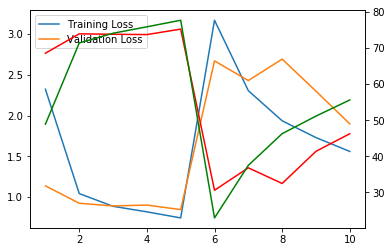

In [8]:
# 7. Visualize result of training
train_loss = model_checkpoint['train_loss']
valid_loss = model_checkpoint['valid_loss']
train_acc = model_checkpoint['train_acc']
valid_acc = model_checkpoint['valid_acc']
train_mcc = model_checkpoint['train_mcc']
valid_mcc = model_checkpoint['valid_mcc']
train_y_true = model_checkpoint['train_y_true']
train_y_pred = model_checkpoint['train_y_pred']
valid_y_true = model_checkpoint['valid_y_true']
valid_y_pred = model_checkpoint['valid_y_pred']

# Plot loss vs accuracy
trainer.plot_loss(arch=base_name, train_loss=train_loss,
                  valid_loss=valid_loss, train_metric=train_acc,
                  valid_metric=valid_acc, metric_title='Accuracy',
                  train_metric_label='Train Accuracy',
                  valid_metric_label='Validation Accuracy')